# Classification After Clustering

Let's train a classifier model to predict the cluster to which a new player will belong to.

In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from sklearn.decomposition import PCA

# Probabilistic Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Neural Network
from sklearn.neural_network import MLPClassifier # Multi-layer Perceptron classifier

# Ensemble
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier

# Grid Search
from sklearn.model_selection import GridSearchCV

# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score

import warnings

warnings.filterwarnings("ignore")

# Loading Dataset

Previously, we have saved the dataset with the cluster labels. Let's load it. It's already preprocessed.

In [167]:
df = pd.read_csv("final_data/clustered_data.csv")
df

,team_name,player_name,player_role,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0,4s,6s,start,end,experience,cluster_id
0,Afghanistan,Hashmatullah Shahidi,Top order Batter,70.0,70.00,11.0,2001.0,97.0,33.91,2962.0,67.55,0.0,18.0,5.0,173,12,2013,2023,10.0,1
1,Afghanistan,Rahmanullah Gurbaz,Wicketkeeper Batter,32.0,32.00,1.0,1182.0,151.0,38.12,1349.0,87.62,5.0,4.0,1.0,107,44,2021,2023,2.0,1
2,Afghanistan,Ibrahim Zadran,Opening Batter,25.0,25.00,2.0,1123.0,162.0,48.82,1366.0,82.21,4.0,5.0,2.0,119,15,2019,2023,4.0,1
3,Afghanistan,Reyaz Hassan,Batter,6.3,5.04,0.0,120.0,50.0,30.00,192.0,62.50,0.0,1.0,0.0,12,2,2022,2023,1.0,0
4,Afghanistan,Rahmat Shah Zurmati,Allrounder,103.0,99.00,4.0,3481.0,114.0,36.64,4902.0,71.01,5.0,25.0,5.0,300,38,2013,2023,10.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,Sri Lanka,Charith Asalanka,Batting Allrounder,47.0,41.00,5.0,1443.0,110.0,40.08,1626.0,88.74,1.0,10.0,2.0,116,28,2021,2023,2.0,1
123,Sri Lanka,Dhananjaya de Silva,Allrounder,88.0,80.00,10.0,1812.0,93.0,25.88,2313.0,78.33,0.0,10.0,4.0,180,15,2016,2023,7.0,1
124,Sri Lanka,Maheesh Theekshana,Bowler,32.0,17.00,6.0,149.0,29.0,13.54,252.0,59.12,0.0,0.0,4.0,8,2,2021,2023,2.0,0
125,Sri Lanka,Kasun Rajitha,Bowler,32.0,17.00,7.0,103.0,33.0,10.30,165.0,62.42,0.0,0.0,3.0,12,1,2018,2023,5.0,0


In [168]:
df["cluster_id"].value_counts()

1    55
0    42
2    19
3    11
Name: cluster_id, dtype: int64

In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   team_name    127 non-null    object 
 1   player_name  127 non-null    object 
 2   player_role  127 non-null    object 
 3   Mat          127 non-null    float64
 4   Inns         127 non-null    float64
 5   NO           127 non-null    float64
 6   Runs         127 non-null    float64
 7   HS           127 non-null    float64
 8   Ave          127 non-null    float64
 9   BF           127 non-null    float64
 10  SR           127 non-null    float64
 11  100          127 non-null    float64
 12  50           127 non-null    float64
 13  0            127 non-null    float64
 14  4s           127 non-null    int64  
 15  6s           127 non-null    int64  
 16  start        127 non-null    int64  
 17  end          127 non-null    int64  
 18  experience   127 non-null    float64
 19  cluster_

# Preparing the Dataset

In [170]:
df_for_model = df.drop(["team_name", "player_name", "player_role"], axis=1)
df_for_model

,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0,4s,6s,start,end,experience,cluster_id
0,70.0,70.00,11.0,2001.0,97.0,33.91,2962.0,67.55,0.0,18.0,5.0,173,12,2013,2023,10.0,1
1,32.0,32.00,1.0,1182.0,151.0,38.12,1349.0,87.62,5.0,4.0,1.0,107,44,2021,2023,2.0,1
2,25.0,25.00,2.0,1123.0,162.0,48.82,1366.0,82.21,4.0,5.0,2.0,119,15,2019,2023,4.0,1
3,6.3,5.04,0.0,120.0,50.0,30.00,192.0,62.50,0.0,1.0,0.0,12,2,2022,2023,1.0,0
4,103.0,99.00,4.0,3481.0,114.0,36.64,4902.0,71.01,5.0,25.0,5.0,300,38,2013,2023,10.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,47.0,41.00,5.0,1443.0,110.0,40.08,1626.0,88.74,1.0,10.0,2.0,116,28,2021,2023,2.0,1
123,88.0,80.00,10.0,1812.0,93.0,25.88,2313.0,78.33,0.0,10.0,4.0,180,15,2016,2023,7.0,1
124,32.0,17.00,6.0,149.0,29.0,13.54,252.0,59.12,0.0,0.0,4.0,8,2,2021,2023,2.0,0
125,32.0,17.00,7.0,103.0,33.0,10.30,165.0,62.42,0.0,0.0,3.0,12,1,2018,2023,5.0,0


In [171]:
X = df_for_model.drop(["cluster_id"], axis=1)
y = df_for_model["cluster_id"]

## Scaling

In [172]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=0, with_std=1)
X_scaled = scaler.fit_transform(X)

X_scaled

array([[1.25249904e+00, 1.34946901e+00, 1.09344699e+00, ...,
        4.02936400e+02, 6.02324785e+02, 2.44712696e+00],
       [5.72570988e-01, 6.16900118e-01, 9.94042717e-02, ...,
        4.04537736e+02, 6.02324785e+02, 4.89425392e-01],
       [4.47321085e-01, 4.81953217e-01, 1.98808543e-01, ...,
        4.04137402e+02, 6.02324785e+02, 9.78850784e-01],
       ...,
       [5.72570988e-01, 3.27728188e-01, 5.96425630e-01, ...,
        4.04537736e+02, 6.02324785e+02, 4.89425392e-01],
       [5.72570988e-01, 3.27728188e-01, 6.95829902e-01, ...,
        4.03937235e+02, 6.02324785e+02, 1.22356348e+00],
       [5.00999615e-01, 3.08450059e-01, 5.96425630e-01, ...,
        4.03737068e+02, 6.02324785e+02, 1.46827618e+00]])

## Dimensionality Reduction


### PCA


In [173]:
def scatter_coefficient(X, normalize=True):
    corr = np.corrcoef(X, rowvar=False)
    if normalize:
        return np.linalg.det(corr) / np.trace(corr)
    else:
        return np.linalg.det(corr)


def psi_index(X, normalize=False):
    corr = np.corrcoef(X, rowvar=False)

    # Eigenvalues and eigenvectors from the correlation matrix
    eig_val, eig_vec = np.linalg.eig(corr)
    idx = eig_val.argsort()[::-1]
    eig_val = eig_val[idx]

    if normalize:
        p = X.shape[0]
        return np.sum((eig_val - 1) ** 2) / (p * (p - 1))
    else:
        return np.sum((eig_val - 1) ** 2)
    

def de_correlate_df(df):
    X_aux = df.copy()
    for col in df.columns:
        X_aux[col] = df[col].sample(len(df)).values
        
    return X_aux

In [174]:
pca = PCA()
pca.fit(df_for_model)
original_variance = pca.explained_variance_ratio_

original_variance

array([9.95088622e-01, 4.32817550e-03, 2.43492050e-04, 1.91131425e-04,
       8.52183147e-05, 3.38164974e-05, 1.64276996e-05, 4.82612841e-06,
       2.86730156e-06, 2.42067057e-06, 1.17452020e-06, 7.48606667e-07,
       6.14147175e-07, 3.89435157e-07, 6.33954628e-08, 1.25938302e-08,
       1.81440008e-11])

### Hypothesis Testing

We will use the following hypothesis test to determine if the data is normally distributed:

```
H0: The data is normally distributed.
H1: The data is not normally distributed.
```

In [175]:

N_permutations = 10000
variance = np.zeros((N_permutations, len(df_for_model.columns)))

for i in range(N_permutations):
    X_aux = de_correlate_df(df_for_model)
    
    pca.fit(X_aux)
    variance[i, :] = pca.explained_variance_ratio_


p_val = np.sum(variance > original_variance, axis=0) / N_permutations
fig = go.Figure()
fig.add_trace(go.Scatter(x=[f'PC{i}' for i in range(len(df_for_model.columns))], y=p_val, name='p-value on significance'))
fig.update_layout(title="PCA Permutation Test p-values")

# We get all p-values are 1, which means that the original variance is not significantly different from the variance of the permuted data. Therefore, we cannot reject the null hypothesis that the data is random. This means that the data is not suitable for PCA.

#### Conclusion on PCA

We get all p-values are 1, which means that the original variance is not significantly different from the variance of the permuted data. Therefore, we cannot reject the null hypothesis that the data is random. This means that the data is not suitable for PCA.

# Model Training

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

model_dict = {}

## Probabilistic Models

### Naive Bayes

In [177]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)


GaussianNB()

In [178]:
y_pred = nb_model.predict(X_test)

model_dict["Naive Bayes"] = {
    "model": nb_model,
    "accuracy": accuracy_score(y_test, y_pred),    
}

print("Naive Bayes:", accuracy_score(y_test, y_pred))

Naive Bayes: 0.8461538461538461


In [179]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      0.67      0.80        15
           2       0.44      0.80      0.57         5
           3       0.83      1.00      0.91         5

    accuracy                           0.85        39
   macro avg       0.82      0.87      0.82        39
weighted avg       0.91      0.85      0.86        39



<Axes: >

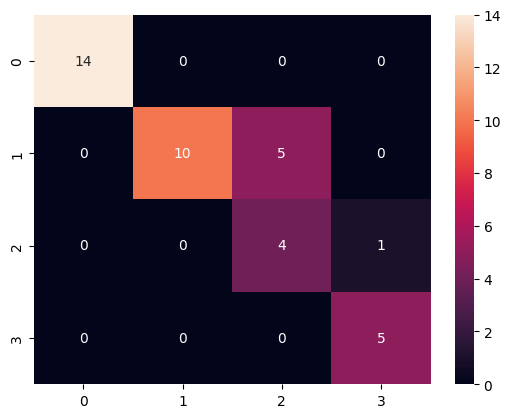

In [180]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")

## Logistic Regression

In [181]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)


LogisticRegression()

In [182]:
y_pred = lr_model.predict(X_test)

model_dict["Logistic Regression"] = {
    "model": lr_model,
    "accuracy": accuracy_score(y_test, y_pred),    
}

print("Logistic Regression:", accuracy_score(y_test, y_pred))

Logistic Regression: 1.0


In [183]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5

    accuracy                           1.00        39
   macro avg       1.00      1.00      1.00        39
weighted avg       1.00      1.00      1.00        39



<Axes: >

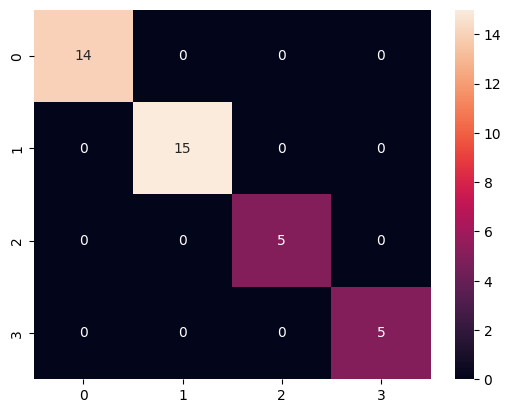

In [184]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")


## KNN (With Hyperparameter Tuning)

In [185]:
# Grid Search KNN

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_model = KNeighborsClassifier()

grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [186]:
grid_search.best_params_

{'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}

In [187]:
print("KNN:", grid_search.best_score_)
model_dict["KNN"] = {
    "model": grid_search.best_estimator_,
    "accuracy": grid_search.best_score_,    
}

KNN: 0.9091503267973856


In [188]:
print(classification_report(y_test, grid_search.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      1.00      1.00        15
           2       0.67      0.80      0.73         5
           3       1.00      0.60      0.75         5

    accuracy                           0.92        39
   macro avg       0.90      0.85      0.86        39
weighted avg       0.93      0.92      0.92        39



<Axes: >

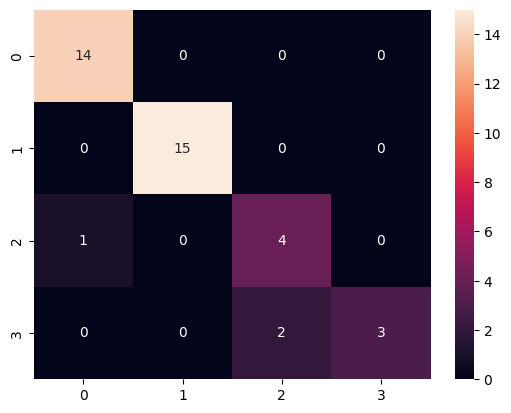

In [189]:
cm = confusion_matrix(y_test, grid_search.predict(X_test))
sns.heatmap(cm, annot=True, fmt="d")

## SVM (With Hyperparameter Tuning)

In [190]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='accuracy', verbose=1)

In [191]:
grid_search.best_params_

{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}

In [192]:
print("SVM:", grid_search.best_score_)
model_dict["SVM"] = {
    "model": grid_search.best_estimator_,
    "accuracy": grid_search.best_score_,    
}

SVM: 0.9209150326797386


In [193]:
print(classification_report(y_test, grid_search.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      1.00      1.00        15
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         5

    accuracy                           0.97        39
   macro avg       0.98      0.95      0.96        39
weighted avg       0.98      0.97      0.97        39



<Axes: >

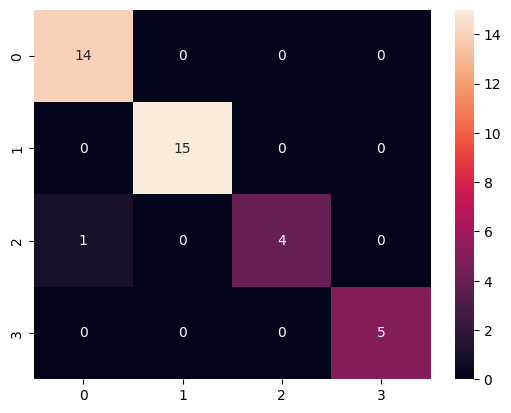

In [194]:
cm = confusion_matrix(y_test, grid_search.predict(X_test))
sns.heatmap(cm, annot=True, fmt="d")

## Decision Tree (With Hyperparameter Tuning)

In [195]:
dt_model = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 9, 11, 13, 15],
    'min_samples_split': [2, 5, 10, 15, 20, 25, 30],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7]
}

grid_search = GridSearchCV(dt_model, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 686 candidates, totalling 3430 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 9, 11, 13, 15],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7],
                         'min_samples_split': [2, 5, 10, 15, 20, 25, 30]},
             scoring='accuracy', verbose=1)

In [196]:
grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 13,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [197]:
print("Decision Tree:", grid_search.best_score_)
model_dict["Decision Tree"] = {
    "model": grid_search.best_estimator_,
    "accuracy": grid_search.best_score_,    
}

Decision Tree: 0.8986928104575164


In [198]:
print(classification_report(y_test, grid_search.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.88      1.00      0.94        15
           2       1.00      0.60      0.75         5
           3       1.00      1.00      1.00         5

    accuracy                           0.95        39
   macro avg       0.97      0.90      0.92        39
weighted avg       0.95      0.95      0.94        39



<Axes: >

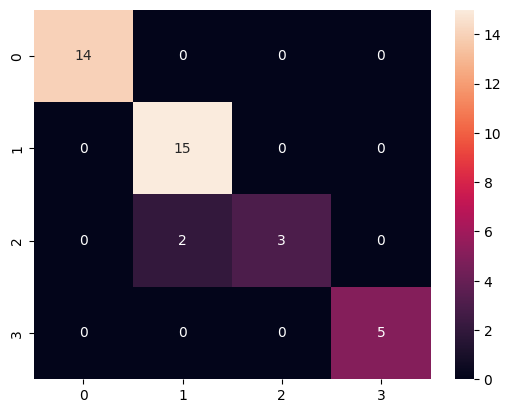

In [199]:
cm = confusion_matrix(y_test, grid_search.predict(X_test))
sns.heatmap(cm, annot=True, fmt="d")

## Ensemble Methods

### Bagging

In [200]:
# bagging

param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_samples': [0.5, 0.7, 0.9, 1.0],
    'max_features': [0.5, 0.7, 0.9, 1.0]
}

grid_search = GridSearchCV(BaggingClassifier(), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5, estimator=BaggingClassifier(), n_jobs=-1,
             param_grid={'max_features': [0.5, 0.7, 0.9, 1.0],
                         'max_samples': [0.5, 0.7, 0.9, 1.0],
                         'n_estimators': [10, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [201]:
grid_search.best_params_


{'max_features': 0.7, 'max_samples': 0.5, 'n_estimators': 10}

In [202]:
print("Bagging:", grid_search.best_score_)
model_dict["Bagging"] = {
    "model": grid_search.best_estimator_,
    "accuracy": grid_search.best_score_,    
}

Bagging: 0.8980392156862745


In [203]:
print(classification_report(y_test, grid_search.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5

    accuracy                           1.00        39
   macro avg       1.00      1.00      1.00        39
weighted avg       1.00      1.00      1.00        39



<Axes: >

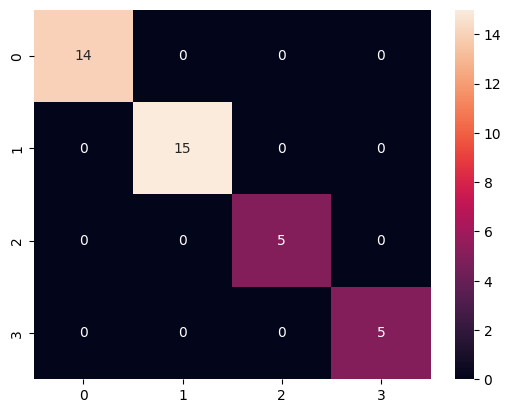

In [204]:
cm = confusion_matrix(y_test, grid_search.predict(X_test))

sns.heatmap(cm, annot=True, fmt="d")

### Gradient Boosting (With Hyperparameter Tuning)

In [205]:
# gradient boosting

param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'max_depth': [3, 5, 7, 9, 11, 13, 15]
}

grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 112 candidates, totalling 560 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5, 1.0],
                         'max_depth': [3, 5, 7, 9, 11, 13, 15],
                         'n_estimators': [10, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [206]:
grid_search.best_params_

{'learning_rate': 1.0, 'max_depth': 5, 'n_estimators': 50}

In [207]:
print("Gradient Boosting:", grid_search.best_score_)
model_dict["Gradient Boosting"] = {
    "model": grid_search.best_estimator_,
    "accuracy": grid_search.best_score_,    
}

Gradient Boosting: 0.9202614379084967


In [208]:
print(classification_report(y_test, grid_search.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.94      1.00      0.97        15
           2       1.00      0.60      0.75         5
           3       0.83      1.00      0.91         5

    accuracy                           0.95        39
   macro avg       0.94      0.90      0.91        39
weighted avg       0.95      0.95      0.94        39



<Axes: >

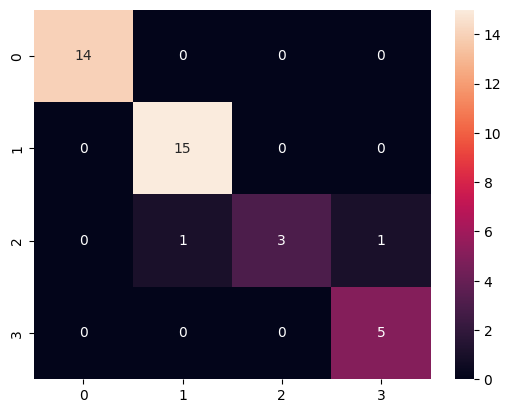

In [209]:
cm = confusion_matrix(y_test, grid_search.predict(X_test))
sns.heatmap(cm, annot=True, fmt="d")

### AdaBoost (With Hyperparameter Tuning)

In [210]:
# AdaBoost

param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0]
}

grid_search = GridSearchCV(AdaBoostClassifier(), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5, 1.0],
                         'n_estimators': [10, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [211]:
grid_search.best_params_

{'learning_rate': 1.0, 'n_estimators': 10}

In [212]:
print("AdaBoost:", grid_search.best_score_)
model_dict["AdaBoost"] = {
    "model": grid_search.best_estimator_,
    "accuracy": grid_search.best_score_,    
}


AdaBoost: 0.841830065359477


In [213]:
print(classification_report(y_test, grid_search.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92        14
           1       0.83      1.00      0.91        15
           2       1.00      0.60      0.75         5
           3       0.83      1.00      0.91         5

    accuracy                           0.90        39
   macro avg       0.92      0.86      0.87        39
weighted avg       0.91      0.90      0.89        39



<Axes: >

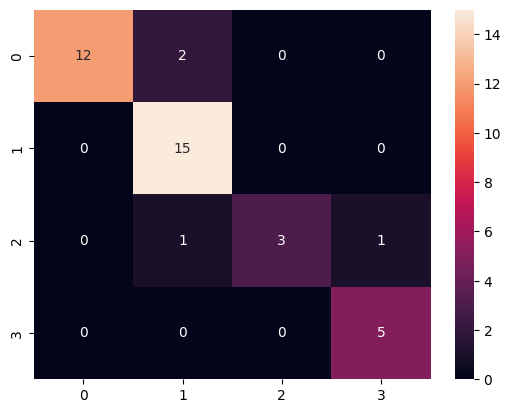

In [214]:
cm = confusion_matrix(y_test, grid_search.predict(X_test))
sns.heatmap(cm, annot=True, fmt="d")

### Random Forest (With Hyperparameter Tuning)

In [215]:
# Random Forest

param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 9, 11, 13, 15],
    'min_samples_split': [2, 5, 10, 15, 20, 25, 30],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 2744 candidates, totalling 13720 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 9, 11, 13, 15],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7],
                         'min_samples_split': [2, 5, 10, 15, 20, 25, 30],
                         'n_estimators': [10, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [216]:
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 10}

In [217]:
print("Random Forest:", grid_search.best_score_)
model_dict["Random Forest"] = {
    "model": grid_search.best_estimator_,
    "accuracy": grid_search.best_score_,    
}

Random Forest: 0.9209150326797386


In [218]:
print(classification_report(y_test, grid_search.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.93      0.93      0.93        15
           2       0.75      0.60      0.67         5
           3       0.83      1.00      0.91         5

    accuracy                           0.92        39
   macro avg       0.88      0.88      0.88        39
weighted avg       0.92      0.92      0.92        39



<Axes: >

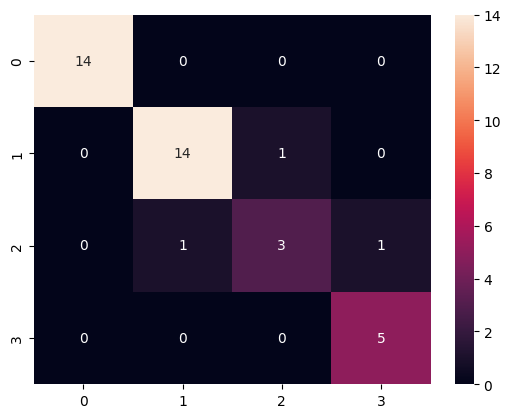

In [219]:
cm = confusion_matrix(y_test, grid_search.predict(X_test))
sns.heatmap(cm, annot=True, fmt="d")

## Neural Networks (Multi-Layer Perceptron)

In [220]:
# Neural Network

mlp_model = MLPClassifier(
    activation='relu',
)
mlp_model.fit(X_train, y_train)


MLPClassifier()

In [221]:
print("Neural Network:", mlp_model.score(X_test, y_test))
model_dict["Neural Network"] = {
    "model": mlp_model,
    "accuracy": mlp_model.score(X_test, y_test),    
}

Neural Network: 0.9487179487179487


In [222]:
print(classification_report(y_test, mlp_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      1.00      1.00        15
           2       0.80      0.80      0.80         5
           3       1.00      0.80      0.89         5

    accuracy                           0.95        39
   macro avg       0.93      0.90      0.91        39
weighted avg       0.95      0.95      0.95        39



<Axes: >

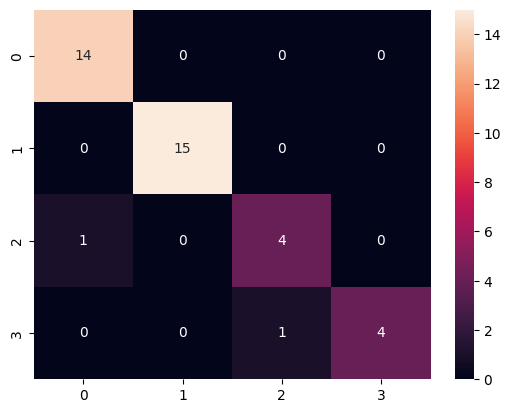

In [223]:
cm = confusion_matrix(y_test, mlp_model.predict(X_test))
sns.heatmap(cm, annot=True, fmt="d")

### FLD (Fisher's Linear Discriminant)

In [224]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

y_pred = lda.predict(X_test)

In [225]:
print("LDA:", accuracy_score(y_test, y_pred))

model_dict["LDA"] = {
    "model": lda,
    "accuracy": accuracy_score(y_test, y_pred),    
}

LDA: 0.8461538461538461


In [226]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       0.93      0.87      0.90        15
           2       0.43      0.60      0.50         5
           3       1.00      0.60      0.75         5

    accuracy                           0.85        39
   macro avg       0.82      0.77      0.78        39
weighted avg       0.88      0.85      0.85        39



<Axes: >

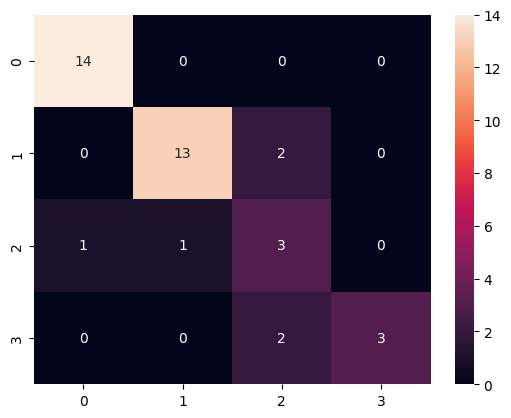

In [227]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")

# Deciding the Best Model

In [228]:
# Deciding the best model

model_df = pd.DataFrame.from_dict(model_dict, orient='index')
model_df.sort_values(by='accuracy', ascending=False, inplace=True)
model_df

,model,accuracy
Logistic Regression,LogisticRegression(),1.000000
Neural Network,MLPClassifier(),0.948718
SVM,"SVC(C=1, gamma='auto')",0.920915
Random Forest,"(DecisionTreeClassifier(max_depth=7, max_featu...",0.920915
Gradient Boosting,([DecisionTreeRegressor(criterion='friedman_ms...,0.920261
KNN,"KNeighborsClassifier(metric='euclidean', n_nei...",0.909150
Decision Tree,"DecisionTreeClassifier(criterion='entropy', ma...",0.898693
Bagging,(DecisionTreeClassifier(random_state=69642012)...,0.898039
Naive Bayes,GaussianNB(),0.846154
LDA,LinearDiscriminantAnalysis(),0.846154


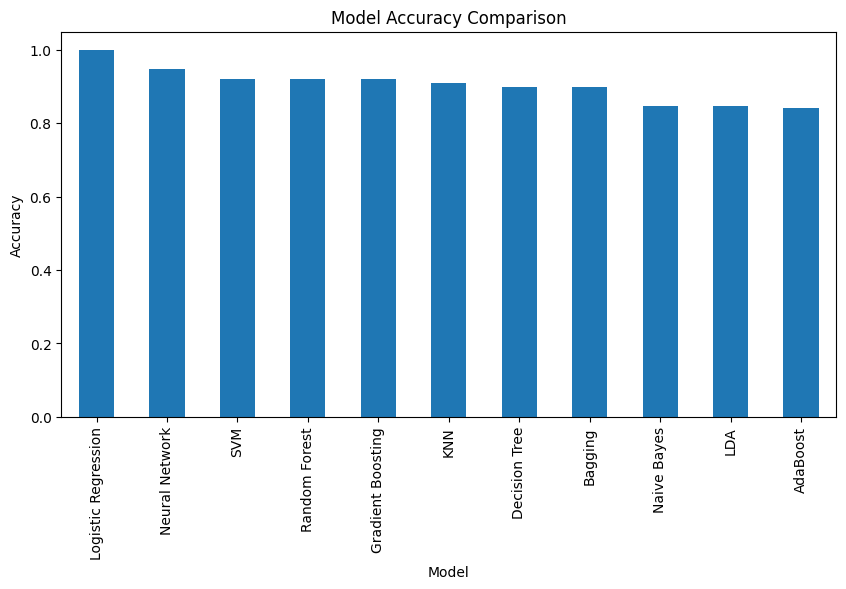

In [229]:
model_df.plot(kind='bar', y='accuracy', figsize=(10, 5), legend=False)
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.title("Model Accuracy Comparison")
plt.show()

# Conclusion

The best model with a whooping `100%` acccuracy turned out to be Logistic Regression!